<a href="https://colab.research.google.com/github/TitasDas/poc-insights-from-images/blob/main/image_captioning_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [ ]:
!pip install -q tqdm

In [ ]:
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tqdm import tqdm

import tensorflow as tf

import matplotlib.pyplot as plt

from google.colab import drive

#**Data Collection**

From coco 2014 dataset, as it was the one with the lowest size

In [ ]:
images = '/train2014/'
if not os.path.exists(os.path.abspath('.') + images):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + images
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 311s 0us/step


In [ ]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

252878848/252872794 [==============================] - 6s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

image_captions_path = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_captions_path[image_path].append(caption)

image_paths = list(image_captions_path.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:10000]
print(len(train_image_paths))

10000


<start> A flock of birds sitting in the trees under a cloudy sky. <end>


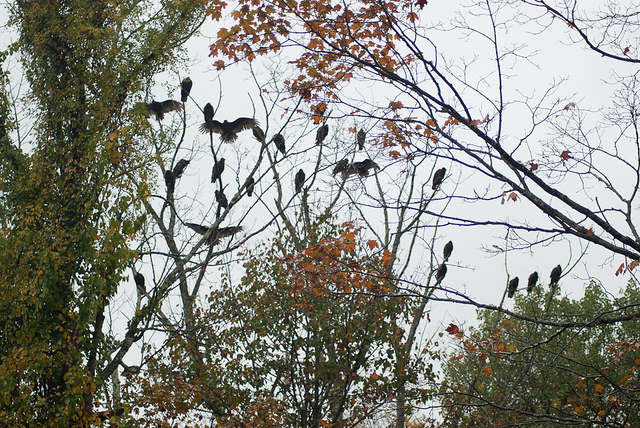

In [ ]:
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
  caption_list = image_captions_path[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))
print(train_captions[1])
Image.open(img_name_vector[1])

In [ ]:
train_captions

['<start> A flock of birds are resting in the tree branches.  <end>',
 '<start> A flock of birds sitting in the trees under a cloudy sky. <end>',
 '<start> A number of birds are perched in the high parts of autumn trees. <end>',
 '<start> Small flock of birds sitting on tree branches. <end>',
 '<start> A bunch of birds perched upon branches of a tree.  <end>',
 '<start> The train is riding past a couple of mountains. <end>',
 '<start> A freight train traveling through a green mountainous area <end>',
 '<start> A black and blue train passing by grassy area next to mountains. <end>',
 '<start> A train riding on train tracks near mountains and grass.  <end>',
 '<start> A large long train on a steel track. <end>',
 '<start> A very cute giraffe sticking out its tongue. <end>',
 '<start> THERE IS A GIRAFFE WITH A LONG TOUNGE EATING A PLANT <end>',
 '<start> a giraffe tongue reaching out to eat some leaves off a tree  <end>',
 '<start> A giraffe eating a bunch of green leaves. <end>',
 '<star

#**Data Preprocessing**


1.   Prepare the images and store the resulting vector after passing them through inception v3
2. Caching the features
2.   Prepare a vocabulary from the captions available



In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 625/625 [02:22<00:00,  4.40it/s]




*   What if we used a different vocabulary and not just the words present in the captions here?



In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

#first try was with just 5000 words
top_k = 50000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

#attention weights are stored in train_seqs
max_length = calc_max_length(train_seqs)

#**Model**


1.   Attention mechanism - Bahdanau
2.   CNN encoder
3. RNN decoder (gated recurrent unit used)



In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#**Training the model:**




1.   Split the dataset into training and testing
2.   Create a dataset in the tf.data format for using to train our model





In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40024, 40024, 10008, 10008)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

## Training steps

*   Pass extracted features through the cnn
*   encoder output, hidden state and 'start' token is passed to decoder which returns predictions and its own hidden state


*   Loss is calculated using the last hidden state and the predictions
*   Teacher forcing - ground truth used as next input to decoder


*   Calculate gradients and apply it to optimizer after which backpropagation is done







In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Epoch 1 Batch 0 Loss 2.4361
Epoch 1 Batch 100 Loss 1.1534
Epoch 1 Batch 200 Loss 1.0750
Epoch 1 Batch 300 Loss 1.0489
Epoch 1 Batch 400 Loss 0.9019
Epoch 1 Batch 500 Loss 0.8738
Epoch 1 Batch 600 Loss 0.7772
Epoch 1 Loss 1.019485
Time taken for 1 epoch 383.11 sec

Epoch 2 Batch 0 Loss 0.8655
Epoch 2 Batch 100 Loss 0.7593
Epoch 2 Batch 200 Loss 0.7259
Epoch 2 Batch 300 Loss 0.7686
Epoch 2 Batch 400 Loss 0.7504
Epoch 2 Batch 500 Loss 0.7079
Epoch 2 Batch 600 Loss 0.6901
Epoch 2 Loss 0.744512
Time taken for 1 epoch 299.35 sec

Epoch 3 Batch 0 Loss 0.6762
Epoch 3 Batch 100 Loss 0.6478
Epoch 3 Batch 200 Loss 0.6297
Epoch 3 Batch 300 Loss 0.6252
Epoch 3 Batch 400 Loss 0.6606
Epoch 3 Batch 500 Loss 0.6219
Epoch 3 Batch 600 Loss 0.5982
Epoch 3 Loss 0.668253
Time taken for 1 epoch 300.69 sec

Epoch 4 Batch 0 Loss 0.5715
Epoch 4 Batch 100 Loss 0.6706
Epoch 4 Batch 200 Loss 0.5941
Epoch 4 Batch 300 Loss 0.6681
Epoch 4 Batch 400 Loss 0.5513
Epoch 4 Batch 500 Loss 0.6372
Epoch 4 Batch 600 Loss 0.60

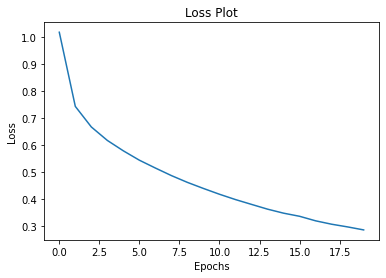

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

#**Testing**

Mounted at /content/drive
Prediction Caption: a man standing with a plate next to each other talking <end>


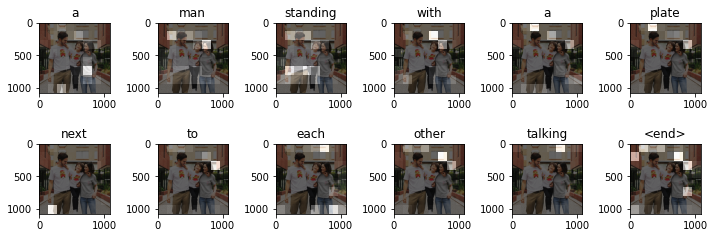

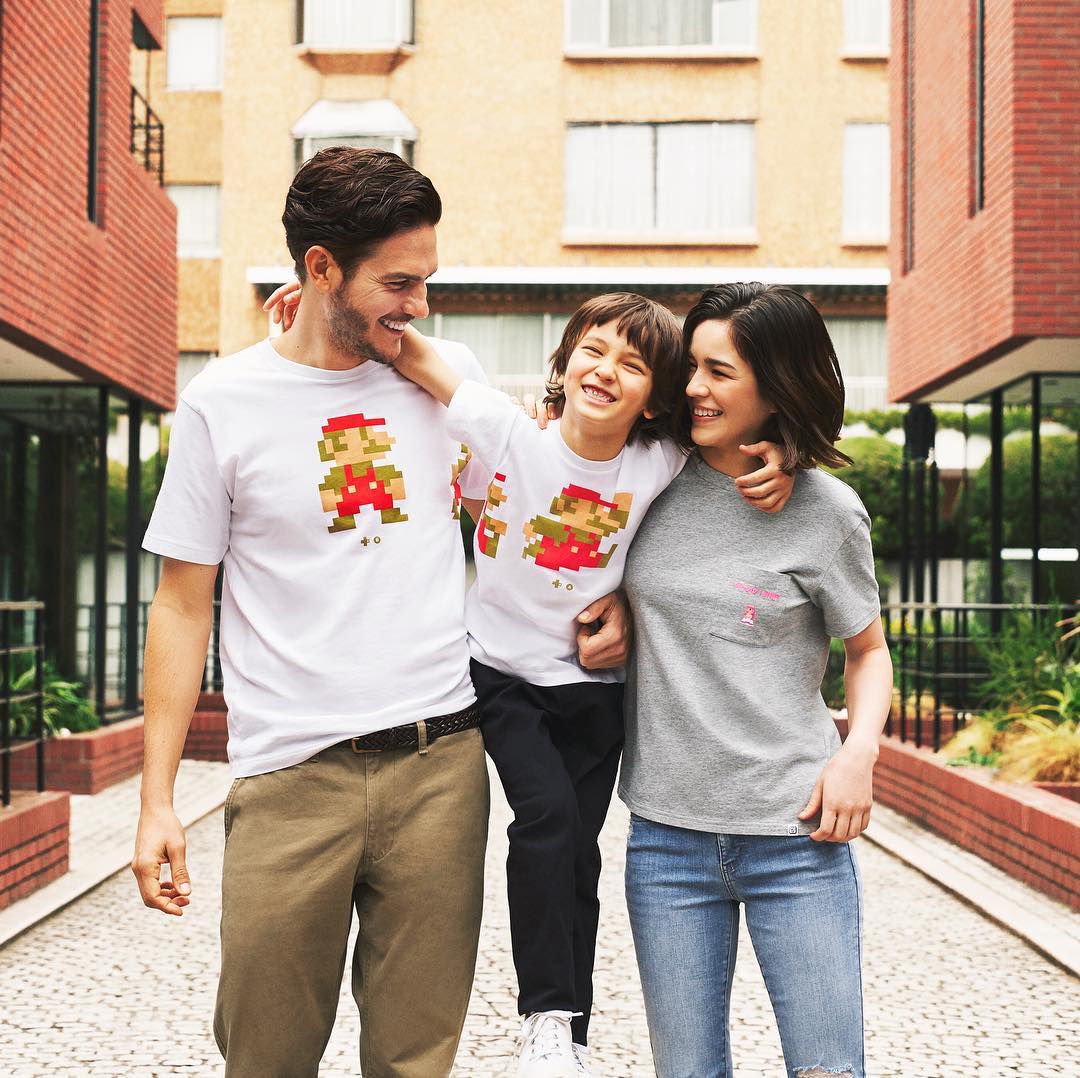

In [ ]:
drive.mount('/content/drive')
image_path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-04-01_14-00-10_UTC.jpg'

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [ ]:
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-09_20-23-28_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-29_15-43-18_UTC_1.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-04-23_13-55-56_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-12_15-58-50_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-31_15-06-53_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-15_15-06-26_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-01_20-58-46_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-22_21-18-59_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-06-26_15-18-46_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-28_15-37-03_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-17_14-51-48_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-06-20_14-55-16_UTC.jpg'